In [1]:
!apt install ffmpeg
!pip install spleeter

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.3/77.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 106.1 MB/s eta 0:00:00
  

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 324, in run
^C


In [2]:
!pip install pydub

In [21]:
import os
import tensorflow as tf
from pydub import AudioSegment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from spleeter.separator import Separator


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset_path = "/content/drive/MyDrive/dataset/final_data_singer"

train_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = True,
    validation_split = 0.2,
    subset = "training",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)


validation_data = tf.keras.utils.audio_dataset_from_directory(
    dataset_path,
    batch_size = 4,
    shuffle = False,
    validation_split = 0.2,
    subset = "validation",
    output_sequence_length = 48000,
    ragged = False,
    label_mode = "categorical",
    labels = "inferred",
    sampling_rate = None,
    seed = 59
)

Found 1836 files belonging to 5 classes.
Using 1469 files for training.
Found 1836 files belonging to 5 classes.
Using 367 files for validation.


In [6]:
train_labels = [y.numpy() for _, y in train_data]
val_labels = [y.numpy() for _, y in validation_data]

print("Train Labels Sample:", train_labels[0])
print("Validation Labels Sample:", val_labels[0])


Train Labels Sample: [[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]]
Validation Labels Sample: [[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [11]:

model = models.Sequential([

    layers.Conv1D(64, kernel_size=80, strides=16, activation="relu", input_shape=(48000, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),


    layers.Conv1D(128, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),


    layers.Conv1D(256, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.3),


    layers.Conv1D(512, kernel_size=3, activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling1D(pool_size=4),
    layers.Dropout(0.4),


    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(5, activation="softmax")
])


In [12]:

model.compile(
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=1e-6),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [13]:

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=20,
    callbacks=[early_stopping, reduce_lr]
)

model.save("/content/drive/MyDrive/pre_trained_model/final_model_singer.keras")

Epoch 1/20
368/368 [==============================] - 51s 132ms/step - loss: 3.2158 - accuracy: 0.4044 - val_loss: 4.2953 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/20
368/368 [==============================] - 48s 130ms/step - loss: 2.1419 - accuracy: 0.5507 - val_loss: 2.5269 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 3/20
368/368 [==============================] - 46s 124ms/step - loss: 1.6887 - accuracy: 0.5766 - val_loss: 2.1337 - val_accuracy: 0.2425 - lr: 0.0010
Epoch 4/20
368/368 [==============================] - 46s 124ms/step - loss: 1.3824 - accuracy: 0.6161 - val_loss: 2.0318 - val_accuracy: 0.3351 - lr: 0.0010
Epoch 5/20
368/368 [==============================] - 47s 126ms/step - loss: 1.1612 - accuracy: 0.6576 - val_loss: 1.2326 - val_accuracy: 0.6322 - lr: 0.0010
Epoch 6/20
368/368 [==============================] - 55s 148ms/step - loss: 1.1384 - accuracy: 0.6685 - val_loss: 0.9628 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 7/20
368/368 [============================

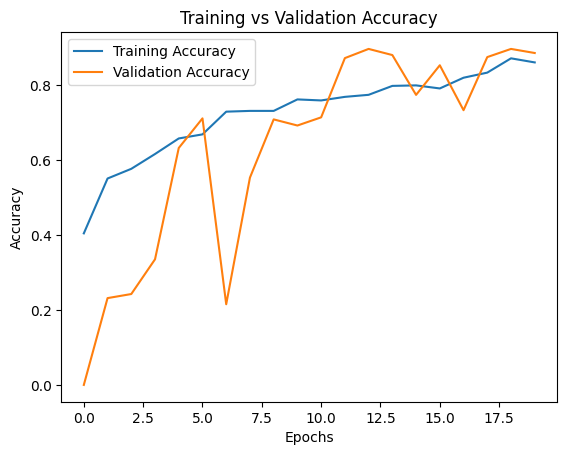

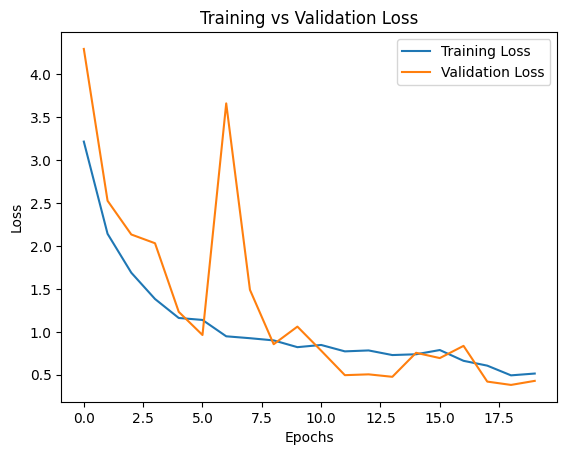

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()


In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

final_metrics = {
    "Epoch": len(train_accuracy),
    "Train Accuracy": train_accuracy[-1],
    "Validation Accuracy": val_accuracy[-1],
    "Train Loss": train_loss[-1],
    "Validation Loss": val_loss[-1]
}

final_metrics_df = pd.DataFrame([final_metrics])


print("\nFinal Training and Validation Metrics:\n")
print(final_metrics_df.to_string(index=False))



Final Training and Validation Metrics:

 Epoch  Train Accuracy  Validation Accuracy  Train Loss  Validation Loss
    20        0.860449             0.885559    0.513928         0.428692


In [16]:
y_gt = np.concatenate([y for _, y in validation_data], axis=0)
y_gt = np.argmax(y_gt, axis=1)
predictions = model.predict(validation_data)
predicted_labels = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_gt, predicted_labels)
conf_matrix


92/92 [==============================] - 5s 51ms/step


array([[  0,   0,   0,   0],
       [  0,   0,   0,   0],
       [  0,   5,  48,   0],
       [ 15,   1,  21, 277]])

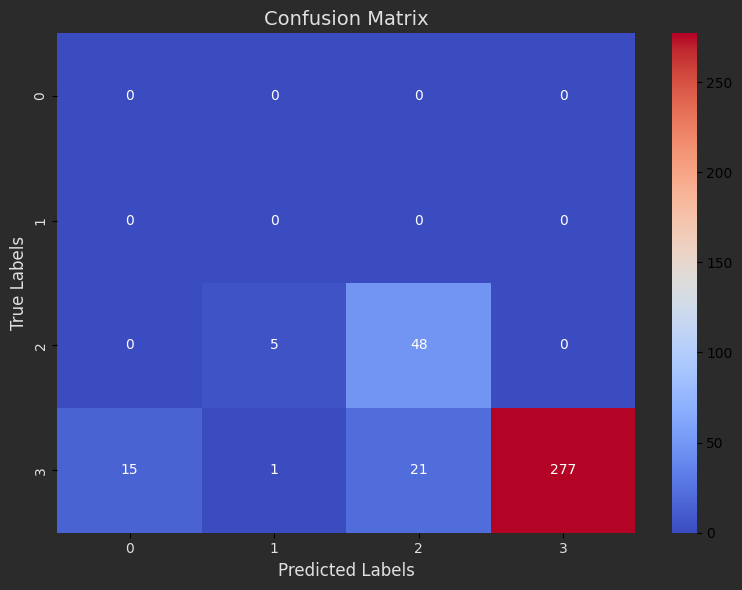

In [17]:
import seaborn as sns

plt.figure(figsize=(8, 6))
fig = plt.gcf()
fig.patch.set_facecolor('#2b2b2b')

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm", cbar=True)
plt.title("Confusion Matrix", fontsize=14, color='#e0e0e0')
plt.xlabel("Predicted Labels", fontsize=12, color='#e0e0e0')
plt.ylabel("True Labels", fontsize=12, color='#e0e0e0')
plt.xticks(color='#e0e0e0')
plt.yticks(color='#e0e0e0')

plt.tight_layout()
plt.show()

In [18]:
print(classification_report(y_gt, predicted_labels))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.70      0.91      0.79        53
           4       1.00      0.88      0.94       314

    accuracy                           0.89       367
   macro avg       0.42      0.45      0.43       367
weighted avg       0.96      0.89      0.92       367



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:


def predict_audio(audio_path):

    vocals_dir = "spleeter_output"
    os.makedirs(vocals_dir, exist_ok=True)

    
    separator = Separator("spleeter:2stems")
    separator.separate_to_file(audio_path, vocals_dir)


    file_name = os.path.splitext(os.path.basename(audio_path))[0]
    vocal_file_path = os.path.join(vocals_dir, file_name, "vocals.wav")


    audio = AudioSegment.from_file(vocal_file_path)
    audio = audio.set_channels(1).set_frame_rate(48000).set_sample_width(2)
    processed_audio_path = "processed_audio.wav"
    audio.export(processed_audio_path, format="wav")


    audio_binary = tf.io.read_file(processed_audio_path)
    audio_tensor, _ = tf.audio.decode_wav(audio_binary, desired_channels=1, desired_samples=48000)


    audio_tensor = tf.expand_dims(audio_tensor, axis=0)


    predictions = model.predict(audio_tensor)
    predicted_class = np.argmax(predictions, axis=1)[0]

    return predicted_class


audio_path = "/content/drive/MyDrive/dataset/raw_data/ebi_1.mp3"
predicted_class = predict_audio(audio_path)
print(f"Predicted class: {predicted_class}")

INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Downloading model archive https://github.com/deezer/spleeter/releases/download/v1.4.0/2stems.tar.gz


INFO:spleeter:Validating archive checksum


INFO:spleeter:Validating archive checksum


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:Extracting downloaded 2stems archive


INFO:spleeter:2stems model file(s) extracted


INFO:spleeter:2stems model file(s) extracted
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.
Instructions for updating:
Use tf.keras instead.


INFO:spleeter:File spleeter_output/ebi_1/vocals.wav written succesfully


INFO:spleeter:File spleeter_output/ebi_1/vocals.wav written succesfully


INFO:spleeter:File spleeter_output/ebi_1/accompaniment.wav written succesfully


INFO:spleeter:File spleeter_output/ebi_1/accompaniment.wav written succesfully


1/1 [==============================] - 0s 56ms/step
Predicted class: 1
